# Imports de bibliotecas necessárias

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

In [2]:
# Definir los directorios y variables estaticas
root_dir = 'png-dataset'
train_dir = 'png-train-dataset'
val_dir = 'png-val-dataset'

# Definir el tamaño de la imagen
img_size = 128

# configurar el tamaño de los hiperparametros de los batch
batch_size = 32

In [3]:
# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar los datos de entrenamiento y validación
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# convertir los datos a iterables (batches)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Imprimir el tamaño de los datasets
print(f"DataLoaders: {train_loader, val_loader}")
print(f"longitud de train_loader: {len(train_loader)} batches de {batch_size} = {len(train_loader)*batch_size} imágenes")
print(f"longitud de train_loader: {len(val_loader)} batches de {batch_size} = {len(val_loader)*batch_size} imágenes")

# comprobamos el interior de los datos de entrenamiento en el Data Loader
train_feature_batch, train_labels_batch = next(iter(train_loader))
train_feature_batch.shape, train_labels_batch.shape

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000020C217156A0>, <torch.utils.data.dataloader.DataLoader object at 0x0000020C21715820>)
longitud de train_loader: 2093 batches de 32 = 66976 imágenes
longitud de train_loader: 524 batches de 32 = 16768 imágenes


(torch.Size([32, 3, 128, 128]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5934205].


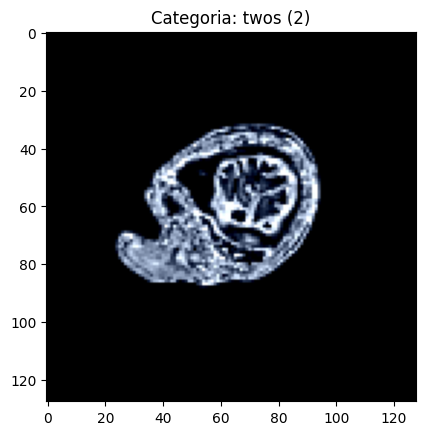

In [4]:
def show_image(img, label):
    # Desnormalizar la imagen
    img = img * 0.5 + 0.5  # Deshace la normalización
    img = img.permute(1, 2, 0)  # Reorganizar las dimensiones para imshow
    img = img.numpy()  # Convertir a numpy
    
    plt.imshow(img)
    plt.title(f"Categoria: {train_dataset.classes[label]} ({label})")
    plt.show()

# Mostrar una imagen de ejemplo normalizada
img, label = train_dataset[60000]
show_image(img, label)



# Funciones utiles para el uso de GPU

In [5]:
def get_default_device():
    #Escoge la GPU si está disponible, de lo contrario la CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Mueve los tensores a la GPU
    if isinstance(data, (list, tuple)):
        return [to_device(x, device)for x in data]
    return data.to(device, non_blocking=True)

def set_gpu_memory_usage(percentage):
    torch.cuda.empty_cache()
    torch.cuda.set_per_process_memory_fraction(percentage)

class DeviceDataLoader():
    #Envuelve un DataLoader para mover los datos a un dispositivo
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    #Itera sobre los batches del DataLoader
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    #Devuelve el número de batches
    def __len__(self):
        return len(self.dl)
    

In [6]:
device = get_default_device()
#set_gpu_memory_usage(0.8)
device

device(type='cuda')

# Modelo ResNet18 Preentrenado

In [7]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [8]:
# Funciones de utilidad para entrenar el modelo
def training_step(model, batch):
    images, labels = batch 
    out = model(images)                  # Generar predicciones
    loss = F.cross_entropy(out, labels) # Calcular la pérdida
    acc = accuracy(out, labels)         # Calcular la precisión
    return loss

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combina las pérdidas
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combina las precisiones
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def validation_step(model, batch):
    images, labels = batch 
    out = model(images)                    # Generar predicciones
    loss = F.cross_entropy(out, labels)   # Calcular la pérdida
    acc = accuracy(out, labels)           # Calcular la precisión
    return {'val_loss': loss.detach(), 'val_acc': acc}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
# Revisamos el tamaño de las imágenes
for images, labels in train_dataset:
    print('images shape is: ', images.shape)
    break

images shape is:  torch.Size([3, 128, 128])


In [10]:
import torchvision.models as models

# Cargar el modelo pre-entrenado
resnet18 = models.resnet18(pretrained=False)
resnet18_num_ftrs = resnet18.fc.in_features

# Cambiar la última capa para clasificar 3 clases
resnet18.fc = nn.Linear(resnet18_num_ftrs, 3)

c:\Users\Pau\Documents\VisualStudioCode\MIA-TFM\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pau\Documents\VisualStudioCode\MIA-TFM\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# Instanciamos el modelo y lo enviamos al dispositivo cuda o cpu
model = to_device(resnet18, device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
summary(model,input_size=(3 , img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

c:\Users\Pau\Documents\VisualStudioCode\MIA-TFM\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# Funcion para evaluar y entrenar

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase de entrenamiento
        model.train()
        train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            loss = training_step(model, batch)         
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Fase de validación
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [15]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

c:\Users\Pau\Documents\VisualStudioCode\MIA-TFM\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0], train_loss: 0.5774, val_loss: 0.7736, val_acc: 0.6249
Epoch [1], train_loss: 0.4123, val_loss: 0.3275, val_acc: 0.8539
Epoch [2], train_loss: 0.3087, val_loss: 0.2656, val_acc: 0.8761
Epoch [3], train_loss: 0.2464, val_loss: 0.2148, val_acc: 0.8986
Epoch [4], train_loss: 0.2082, val_loss: 0.2584, val_acc: 0.8806
Epoch [5], train_loss: 0.1831, val_loss: 0.3544, val_acc: 0.8430
Epoch [6], train_loss: 0.1634, val_loss: 0.2211, val_acc: 0.9003
Epoch [7], train_loss: 0.1493, val_loss: 0.1716, val_acc: 0.9206
Epoch [8], train_loss: 0.1388, val_loss: 0.1971, val_acc: 0.9102
Epoch [9], train_loss: 0.1285, val_loss: 0.2254, val_acc: 0.9020
Epoch [10], train_loss: 0.1224, val_loss: 0.1761, val_acc: 0.9210
Epoch [11], train_loss: 0.1151, val_loss: 0.2590, val_acc: 0.9033
Epoch [12], train_loss: 0.1063, val_loss: 0.1471, val_acc: 0.9316
Epoch [13], train_loss: 0.1028, val_loss: 0.2431, val_acc: 0.9061
Epoch [14], train_loss: 0.0950, val_loss: 0.1657, val_acc: 0.9292
Epoch [15], train_lo

# Evaluación del modelo

In [16]:
# Obtener las predicciones para el conjunto de validación
model.eval()
y_true = []
y_pred = []

for images, labels in val_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true += labels.cpu()
    y_pred += preds.cpu()

In [17]:
# Precision vs Epoch y Perdida vs Epoch
def plot_accuracies(history):
    # Ajustar el tamaño de la figura
    plt.figure(figsize=(12, 6))  # Ancho: 12 pulgadas, Altura: 6 pulgadas

    # Gráfico de precisión
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Precisión')
    plt.title('Precisión vs. Epoch')

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Perdida')
    plt.legend(['Training', 'Validation'])
    plt.title('Perdida vs. Epoch')

    # Mostrar los gráficos
    plt.tight_layout()  # Ajustar el diseño para que no se superpongan los gráficos
    plt.show()

# Matriz de Confusión (Confusion Matrix)
def plot_confusion_matrix(y_true, y_pred, classes):
    plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Verdaderas (Ground Truth)')
    plt.title('Matriz de Confusión')
    plt.show()

# Función para graficar la curva ROC
def plot_roc_curve(y_true, y_pred, n_classes):
    # Se tiene que binariazar las etiquetas
    y_true = label_binarize(y_true, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC para la clase {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadero Positive')
    plt.title('Curva ROC para multi-clases')
    plt.legend(loc="lower right")
    plt.show()

# Función para graficar la curva de Precisión-Recall
def plot_precision_recall(y_true, y_pred, n_classes):
    # Se tiene que binariazar las etiquetas
    y_true = label_binarize(y_true, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    # Plot PR curve for each class
    plt.figure()
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Precision-recall para la clase {0} (area = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precisión-Recall para multi-clases')
    plt.legend(loc="best")
    plt.show()

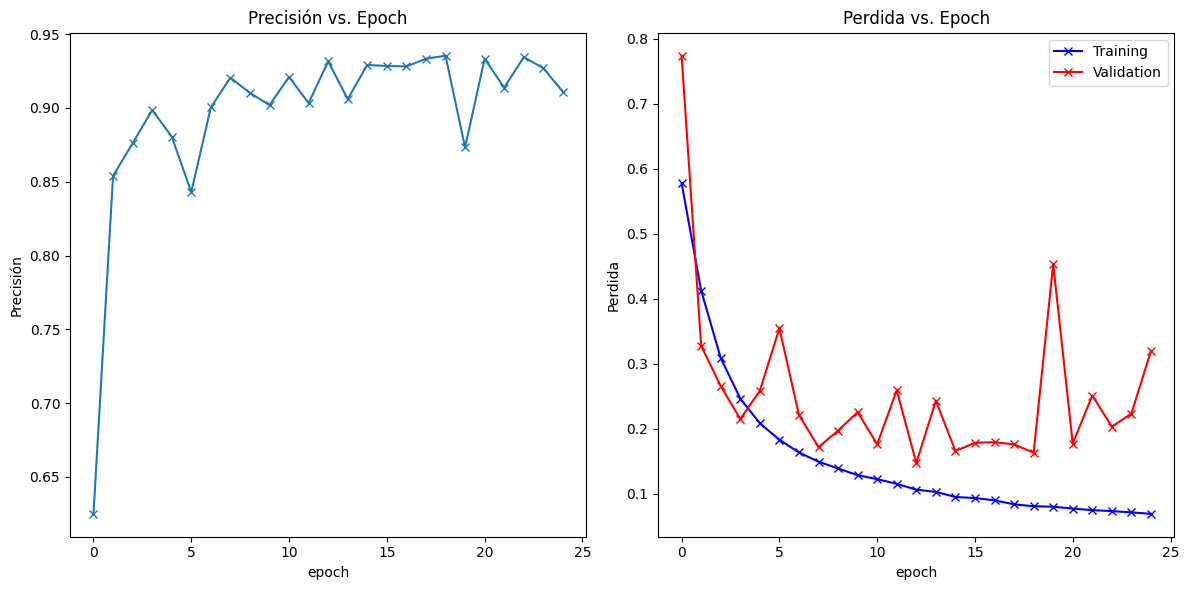

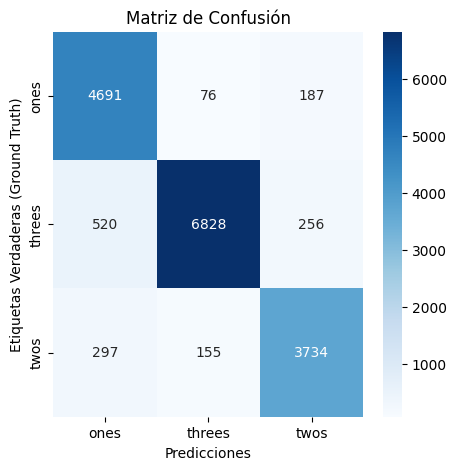

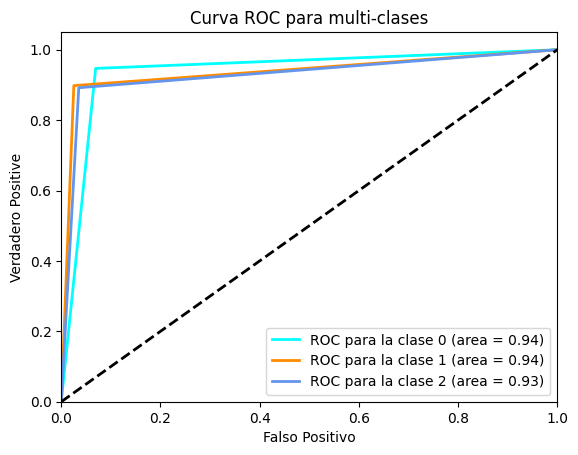

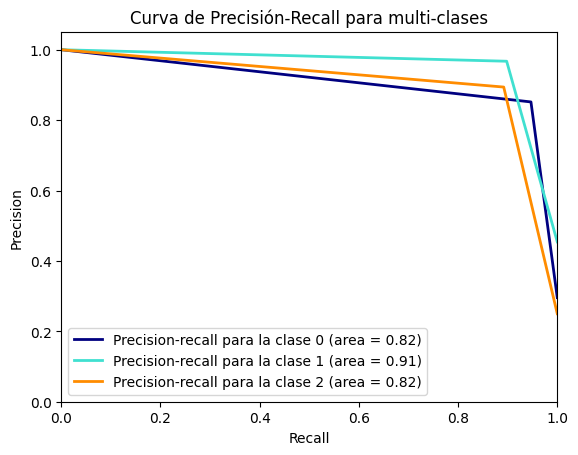

In [18]:
# Precision y Error
plot_accuracies(history)

# Matriz de confusión
plot_confusion_matrix(y_true, y_pred, train_dataset.classes)

# Curva ROC
plot_roc_curve(y_true, y_pred, n_classes=len(train_dataset.classes))

# Curva de Precisión-Recall
plot_precision_recall(y_true, y_pred, n_classes=len(train_dataset.classes))


Sensibilidad (Recall)= TP/TP+FN


Clase ones = 0.947

Clase twos = 0.892

Clase threes = 0.898
​

Especificidad= TN/TN+FP


Clase ones = 0.931

Clase twos = 0.965

Clase threes = 0.975

# Test del modelo con una imagen del dataset de validación

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


Categoria Correcta: twos , Predicción: twos


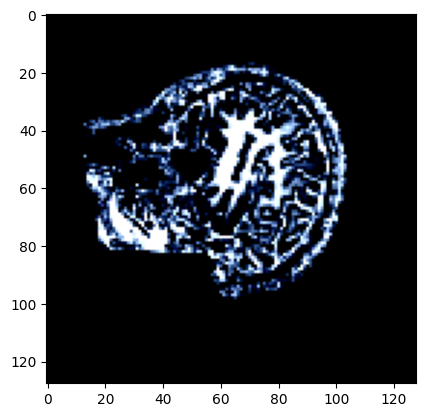

In [19]:
def test_image(img, model):
    # Convertir la imagen a un batch de un solo elemento
    xb = to_device(img.unsqueeze(0), device)
    # Obtener las predicciones del modelo
    yb = model(xb)
    # Escoger el punto de entrenamiento con la mayor probabilidad
    _, preds  = torch.max(yb, dim=1)
    return val_dataset.classes[preds[0].item()]

# Seleccionar una imagen random del dataset de validación
random = torch.randint(0, len(val_dataset), (1,)).item()
img, label = val_dataset[random]
plt.imshow(img.permute(1, 2, 0))
print('Categoria Correcta:', val_dataset.classes[label], ', Predicción:', test_image(img, model))

# Evaluacion Grad-CAM de la segunda capa convolucional

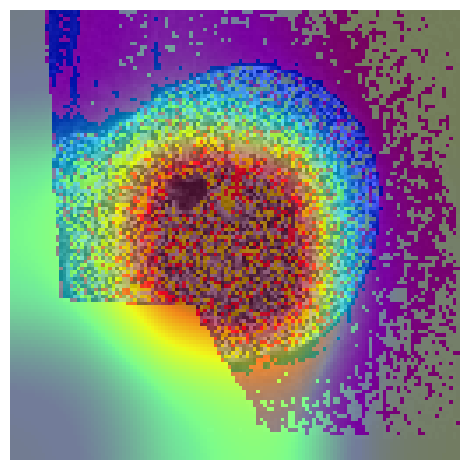

In [20]:
# Crear una instancia de GradCAM++
img = to_device(img, device)

with SmoothGradCAMpp(model, target_layer=model.layer4[1].conv2) as cam_extractor:
  out = model(img.unsqueeze(0))
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)


def to_pil_image(img, mode=None):
    # Convertir el tensor a imagen PIL
    return transforms.ToPILImage(mode=mode)(img.cpu().clone().detach().squeeze())

result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

# Guardamos el modelo

In [21]:
torch.save(model.state_dict(), 'ResNet18_No_Pretrained.pth')